In [62]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import seaborn as sns
import tensorflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.random import set_random_seed
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.regularizers import l1, l2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

set_random_seed(0)
np.random.seed(0)

In [57]:
import os
os.chdir(r'/kaggle/working')

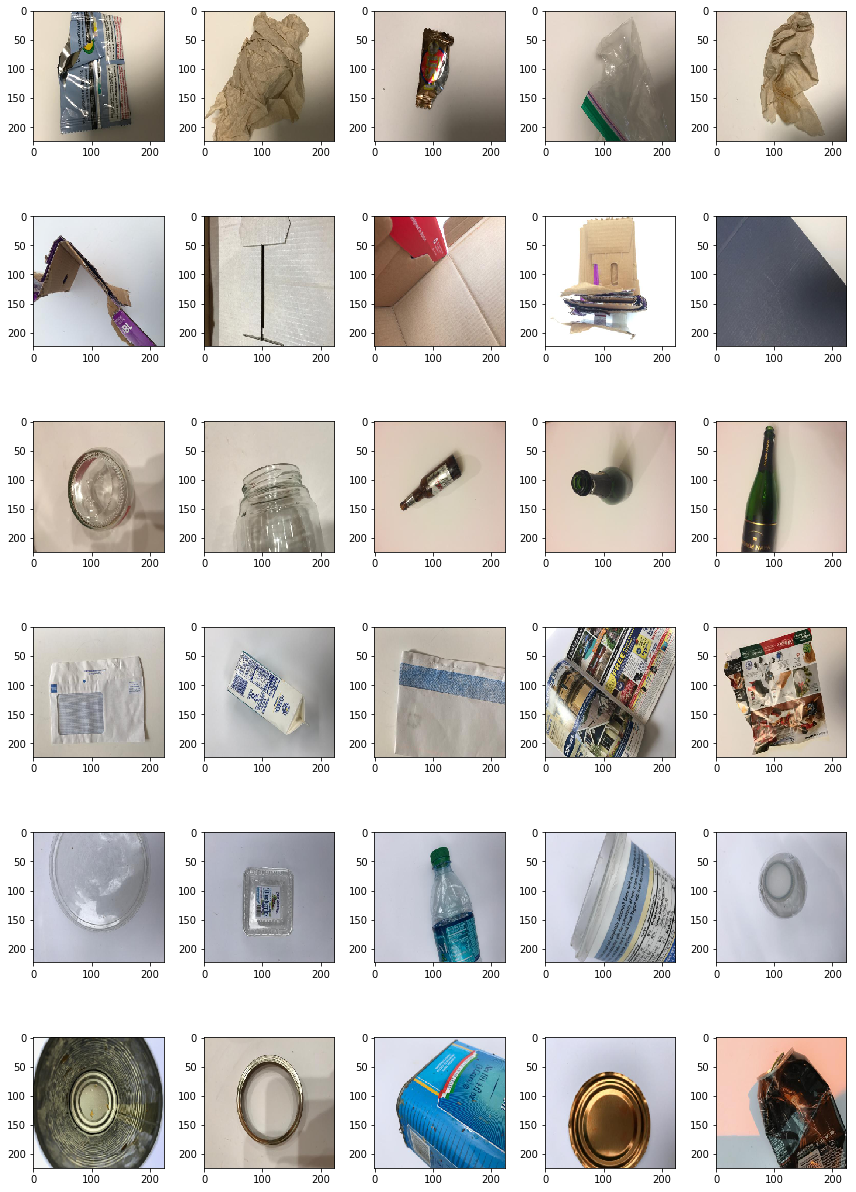

In [58]:
# display some images for every different expression

import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 224

# input path for the images
base_path = "../input/split-garbage-dataset/split-garbage-dataset/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

# Data preprocessing

In [59]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(
        rescale = 1./255
)
test_datagen = ImageDataGenerator(
        rescale = 1./255
)

In [60]:
img_shape = (224, 224, 3) # default values

train_batch_size = 256
val_batch_size = 32

train_generator = train_datagen.flow_from_directory(
            base_path + '/train',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = train_batch_size,
            class_mode = 'categorical',)

validation_generator = validation_datagen.flow_from_directory(
            base_path + '/valid',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False)

test_generator = test_datagen.flow_from_directory(
            base_path + '/test',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False,)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


# Building model without improvement

In [63]:
# Create the model
model = Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    # The second convolution
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The third convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The fourth convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The fifth convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    Flatten(),
    # 512 neuron hidden layer
    Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    Dense(6, activation='softmax')
])
model.compile(loss='categorical_crossentropy',
              optimizer=Nadam(lr=1e-4),
              metrics=['acc'])
# Train the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('Garbage no improvement Classifier.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size ,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    verbose=0,
    callbacks = [es, mc],)

11/11 [==============================] - 2s 226ms/step - loss: 1.7567 - acc: 0.2530

Epoch 00001: val_acc improved from -inf to 0.25305, saving model to Garbage no improvement Classifier.h5
11/11 [==============================] - 2s 169ms/step - loss: 1.7668 - acc: 0.2530

Epoch 00002: val_acc did not improve from 0.25305
11/11 [==============================] - 2s 159ms/step - loss: 1.7653 - acc: 0.2530

Epoch 00003: val_acc did not improve from 0.25305
11/11 [==============================] - 2s 215ms/step - loss: 1.7293 - acc: 0.2927

Epoch 00004: val_acc improved from 0.25305 to 0.29268, saving model to Garbage no improvement Classifier.h5
11/11 [==============================] - 2s 169ms/step - loss: 1.6842 - acc: 0.3841

Epoch 00005: val_acc improved from 0.29268 to 0.38415, saving model to Garbage no improvement Classifier.h5
11/11 [==============================] - 2s 180ms/step - loss: 1.6507 - acc: 0.3415

Epoch 00006: val_acc did not improve from 0.38415
11/11 [============

# Train the model without improvement

# Building model

## Pretrained Convolutional Base (mobilenet)

In [64]:
vgg = VGG16(weights = 'imagenet',
              include_top = False,
              input_shape = img_shape)

58892288/58889256 [==============================] - 2s 0us/step


## Fine-tuning

### Freeze mobilenet layers

In [65]:
# Freeze the layers except the last 3 layers
for layer in vgg.layers[:-3]:
    layer.trainable = False

### Model definition

In [66]:
# Create the model
model = Sequential()
 
# Add the mobilenet convolutional base model
model.add(vgg)
# Add new layers
model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 150534    
Total params: 14,865,222
Trainable params: 4,870,150
Non-trainable params: 9,995,072
_________________________________________________________________


# Train the model with improvement

In [68]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Nadam(lr=1e-4),
              metrics=['acc'])

In [69]:
# Train the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('VGG16 Garbage Classifier.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size ,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    verbose=0,
    callbacks = [es, mc],)

11/11 [==============================] - 4s 375ms/step - loss: 1.6325 - acc: 0.3963

Epoch 00001: val_acc improved from -inf to 0.39634, saving model to VGG16 Garbage Classifier.h5
11/11 [==============================] - 2s 185ms/step - loss: 1.3912 - acc: 0.5122

Epoch 00002: val_acc improved from 0.39634 to 0.51220, saving model to VGG16 Garbage Classifier.h5
11/11 [==============================] - 2s 202ms/step - loss: 1.1582 - acc: 0.6037

Epoch 00003: val_acc improved from 0.51220 to 0.60366, saving model to VGG16 Garbage Classifier.h5
11/11 [==============================] - 2s 178ms/step - loss: 1.0912 - acc: 0.5945

Epoch 00004: val_acc did not improve from 0.60366
11/11 [==============================] - 2s 204ms/step - loss: 0.9459 - acc: 0.6646

Epoch 00005: val_acc improved from 0.60366 to 0.66463, saving model to VGG16 Garbage Classifier.h5
11/11 [==============================] - 2s 181ms/step - loss: 0.8474 - acc: 0.6921

Epoch 00006: val_acc improved from 0.66463 to 0

### Training history

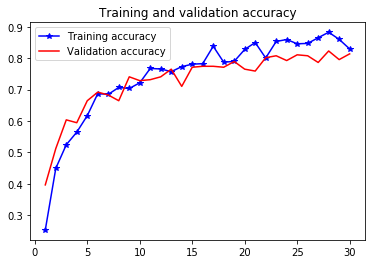

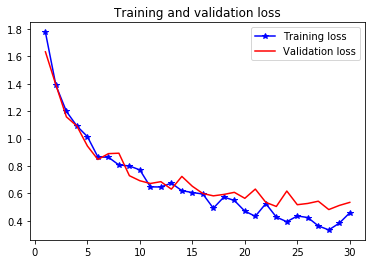

In [70]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Prediction on test set

In [71]:
data = np.load('../input/test-data/test_data.npz')
x_test, y_test = data['x_test'], data['y_test']
y_pred = model.predict(x_test)

# Model evaluation

## Test set accuracy

In [72]:
acc = np.count_nonzero(np.equal(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1)))/x_test.shape[0]
print(acc)

0.8167053364269141


## Confusion Matrix and per-class accuracy

In [73]:
confusion_matrix = np.zeros((6,6), dtype=np.uint8)
per_class_acc = np.zeros(6)
for i in range(y_test.shape[1]):
    idxs = np.argmax(y_test, axis=1)==i
    this_label = y_test[idxs]
    num_samples_per_class = np.count_nonzero(idxs)
    one_hot = tensorflow.one_hot(np.argmax(model.predict(x_test[idxs]), axis=1), depth=6).eval(session=tensorflow.Session())
    confusion_matrix[i] = np.sum(one_hot, axis=0)
    per_class_acc[i] = confusion_matrix[i,i]/num_samples_per_class

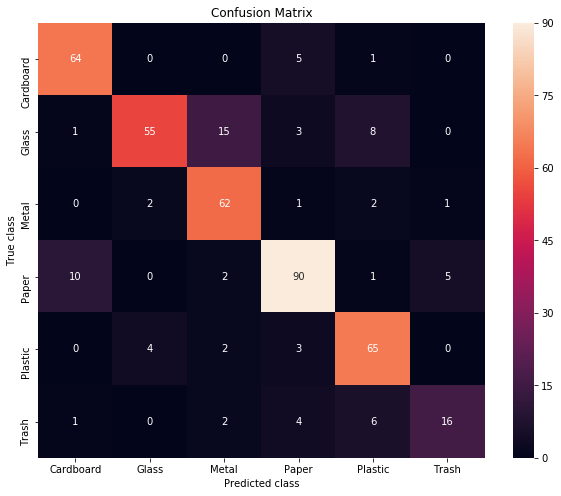

In [74]:
LABELS=['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = 'd')
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [75]:
dict(zip(LABELS, per_class_acc))

{'Cardboard': 0.9142857142857143,
 'Glass': 0.6707317073170732,
 'Metal': 0.9117647058823529,
 'Paper': 0.8333333333333334,
 'Plastic': 0.8783783783783784,
 'Trash': 0.5517241379310345}